# Anomaly Detection - coding exercise

In this coding exercise, you will explore how unsupervised deep learning can be used to detect anomalies. The anomalies are simulated in form of out-of-distribution samples in a set of medical images. Two types of neural networks - an autoencoder and a variational autoencoder - will be implemented to detect these outliers without having access to examples of the anomalies during training.

### Set up directories

In [ ]:
! git init
! git remote add origin https://github.com/martinmenten/anomaly-detection-tutorial.git
! git fetch
! git checkout -t origin/main

### Imports and configuration

In [9]:
from argparse import Namespace
from collections import defaultdict
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import DataLoader

from mednist import (
    MEDNISTDIR,
    download_mednist,
    get_anomal_files,
    get_normal_files,
    MedNISTDataset,
    MedNISTTestDataset
)
from models import Autoencoder, VAE
from utils import plot, plot_anomaly_scores

# Select device to train on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Config
config = Namespace()
config.batch_size = 128
config.val_split = 0.8
config.test_split = 0.9
config.device = device

# Reproducibility
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# Autoreload modules without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download MedNIST and create DataLoader

For this exercise, we will use the [MedNIST](https://medmnist.com) dataset [1,2]. The first cell below downloads parts of the the dataset and prepares training, validation and testing datasets and dataloaders. We define hand x-ray scans as our "normal samples" and create training and validation datasets that consist entirely of such x-rays. The test images, however, are evenly split between hand x-rays and anomal medical images, such as mammographs, chest x-rays as well as head, chest and abdominal computed tomography images. By running the second cell, samples from each dataset are presented.

In [10]:
# Download if necessary
download_mednist(MEDNISTDIR)

# Get all HeadCT and Hand files
normal_files = get_normal_files(MEDNISTDIR, normal_class='Hand')
anomal_files = get_anomal_files(MEDNISTDIR, normal_class='Hand')
random.shuffle(anomal_files)  # Were sorted by class before
anomal_files = anomal_files[:len(normal_files)]  # Assure number of files are equal

# Create a training / validation / test split
val_split_idx = int(len(normal_files) * config.val_split)
test_split_idx = int(len(normal_files) * config.test_split)

# Take 80% normal images for training
train_files = normal_files[:val_split_idx]

# Take 10% normal images for validation
val_files = normal_files[val_split_idx:test_split_idx]

# Take 10% normal images and an equal amount of anomal images
test_files_1 = normal_files[test_split_idx:]
test_files_2 = anomal_files[test_split_idx:]
test_labels_1 = [0 for _ in range(len(test_files_1))]  # normal files are in-distribution -> 0
test_labels_2 = [1 for _ in range(len(test_files_2))]  # anomal files are out-of-distribution -> 1
test_files = test_files_1 + test_files_2
test_labels = test_labels_1 + test_labels_2

# Create a training dataset with normal files
train_ds = MedNISTDataset(train_files)
trainloader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

# Create a validation dataset with normal files
val_ds = MedNISTDataset(val_files)
valloader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)

# Create a test dataset with normal and anomal files
test_ds = MedNISTTestDataset(test_files, test_labels)
testloader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=True)

print('Training dataset size:', len(train_ds))
print('Validation dataset size:', len(val_ds))
print('Test dataset size:', len(test_ds))

Training dataset size: 8000
Validation dataset size: 1000
Test dataset size: 2000


Training images


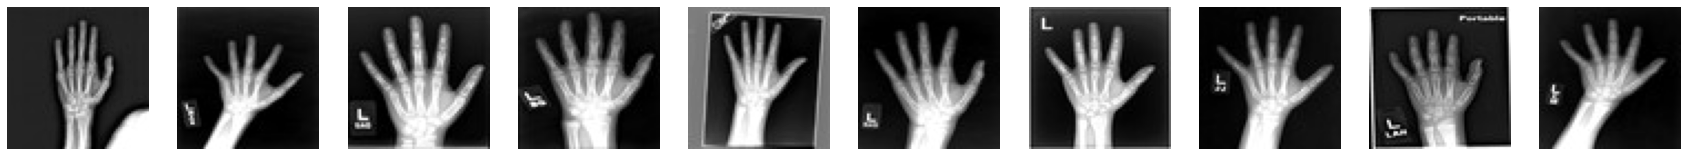

Validation images


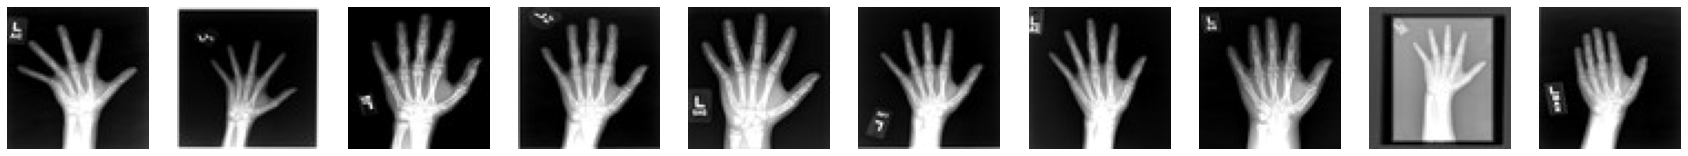

Test images


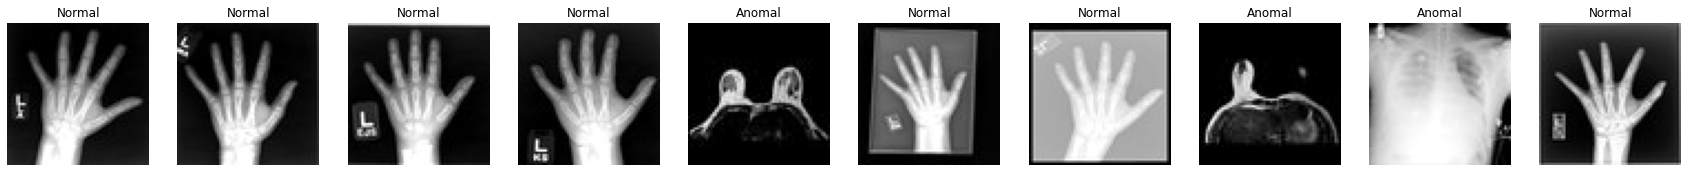

In [11]:
print('Training images')
plot([img for img in next(iter(trainloader))[:10, 0]])
print('Validation images')
plot([img for img in next(iter(valloader))[:10, 0]])
print('Test images')
imgs, labels = next(iter(testloader))
labels = ["Normal" if label == 0 else "Anomal" for label in labels]
plot([img for img in imgs[:10, 0]], titles=labels[:10])

### Autoencoder

The first anomaly detection strategy is based on a convolutional autoencoder. It consists of an encoder comprised of three convolutional blocks, a bottleneck and a decoder consisting of three convolutional blocks. The next two two cells 

In [12]:
# Autoencoder training functions

def ae_train_step(ae, x, optimizer, device):
    ae.train()
    optimizer.zero_grad()
    x = x.to(device)
    x_recon = ae(x)
    loss = ae.loss_function(x, x_recon)  # MSE loss
    loss.backward()
    optimizer.step()
    return loss.item()


def ae_val_step(ae, x, device):
    ae.eval()
    x = x.to(device)
    with torch.no_grad():
        x_recon = ae(x)
    return ae.loss_function(x, x_recon).item(), x_recon


def train_ae(config, ae, optimizer, trainloader, valloader):
    i_step = 0
    i_epoch = 0
    all_losses = []
    losses = []
    ae.train()
    while True:
        for x in trainloader:
            # Train step
            loss = ae_train_step(ae, x, optimizer, config.device)

            # Store metrics
            losses.append(loss)
            all_losses.append(loss)

            # Log
            if i_step % config.log_frequency == 0:
                print(f'Iteration {i_step} - train loss {np.mean(losses):.4f}')
                losses = []

            # Validate
            if i_step % config.val_frequency == 0:
                val_loss, x_val, x_recon = validate_ae(config, ae, valloader)
                print(f'Iteration {i_step} - val loss {val_loss:.4f}')
                residual = torch.abs(x_val - x_recon)
                plot([x_val[0, 0], x_recon[0, 0], residual[0, 0]],
                     titles=['input', 'reconstruction', 'residual'])

            # Finish
            i_step += 1
            if i_step >= config.num_steps:
                print('Finished training')
                return ae, all_losses
        i_epoch += 1
        print(f'Finished epoch {i_epoch}')


def validate_ae(config, ae, valloader):
    losses = []
    for x in valloader:
        loss, x_recon = ae_val_step(ae, x, config.device)
        losses.append(loss)
    return np.mean(losses), x.cpu(), x_recon.cpu()

In [13]:
# Train config
config.lr = 1e-3
config.num_steps = 1000
config.log_frequency = 50
config.val_frequency = 100
config.latent_dim = 128

# Initialize Autoencoder
ae = Autoencoder(latent_dim=config.latent_dim).to(device)
#print(ae)

# Optimizer
optimizer = torch.optim.Adam(ae.parameters(), lr=config.lr)

# Train
print('Start training...')
ae, ae_loss_history = train_ae(config, ae, optimizer, trainloader, valloader)

# Plot loss history
plt.plot(ae_loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0, 0.2)
plt.show()

Autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (bottleneck): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
  )
  (decoder_input): Sequential(
    (0): Linear(in_features=128, out_featu

NameError: name 'ae_train_step' is not defined

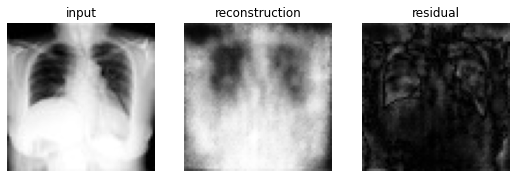

In [43]:
# Testing

def ae_test_step(ae, x, device):
    ae.eval()
    x = x.to(device)
    with torch.no_grad():
        x_recon = ae(x)
    return x.cpu(), x_recon.cpu(), torch.abs(x - x_recon).cpu()

def test_ae(config, ae, testloader):
    scores = []
    labels = []
    ae.eval()
    for x, y in testloader:
        x, x_recon, residual = ae_test_step(ae, x, config.device)
        anomaly_score = torch.mean(residual, dim=(1, 2, 3))
        scores.extend(anomaly_score.numpy())
        labels.extend(y.numpy())

    # Plot an anomalous test sample
    if len(y == 1) > 0:
        plot([x[y == 1][0, 0], x_recon[y == 1][0, 0], residual[y == 1][0, 0]],
                titles=['input', 'reconstruction', 'residual'])

    return np.array(scores), np.array(labels)

ae_scores, ae_labels = test_ae(config, ae, testloader)

ROC AUC: 0.9865


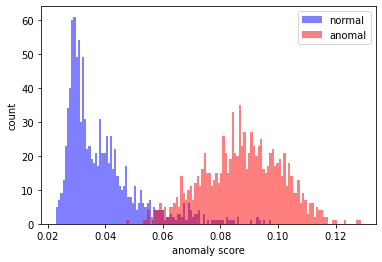

In [44]:
# Evaluation
auroc = roc_auc_score(ae_labels, ae_scores)
print(f'ROC AUC: {auroc:.4f}')

plot_anomaly_scores(ae_scores, ae_labels)

# Variational Autoencoder

In [9]:
# VAE training functions

def vae_train_step(vae, x, optimizer, device):
    vae.train()
    optimizer.zero_grad()
    x = x.to(device)
    x_recon, mu, logvar = vae(x)
    loss_dict = vae.loss_function(x, x_recon, mu, logvar, kl_weight=2.0)  # VAE loss
    loss = loss_dict['loss']
    loss.backward()
    optimizer.step()
    return loss_dict


def vae_val_step(vae, x, device):
    vae.eval()
    x = x.to(device)
    with torch.no_grad():
        x_recon, mu, logvar = vae(x)
    loss_dict = vae.loss_function(x, x_recon, mu, logvar, kl_weight=2.0)
    return loss_dict, x_recon.cpu()


def train_vae(config, vae, optimizer, trainloader, valloader):
    i_step = 0
    i_epoch = 0
    all_losses = defaultdict(list)
    losses = defaultdict(list)
    vae.train()
    while True:
        for x in trainloader:
            # Train step
            loss_dict = vae_train_step(vae, x, optimizer, config.device)

            # Store metrics
            for k, v in loss_dict.items():
                losses[k].append(v.item())
                all_losses[k].append(v.item())

            # Log
            if i_step % config.log_frequency == 0:
                losses = {k: np.mean(v) for k, v in losses.items()}
                log_msg = f'Iteration {i_step}'
                for k, v in losses.items():
                    log_msg += f' - {k}: {v:.4f}'
                print(log_msg)
                losses = defaultdict(list)

            # Validate
            if i_step % config.val_frequency == 0:
                val_losses, x_val, x_recon = validate_vae(config, vae, valloader)
                log_msg = f'Iteration {i_step}'
                for k, v in val_losses.items():
                    log_msg += f' - val {k}: {v:.4f}'
                print(log_msg)
                residual = torch.abs(x_val - x_recon)
                plot([x_val[0, 0], x_recon[0, 0], residual[0, 0]],
                     titles=['input', 'reconstruction', 'residual'])

            # Finish
            i_step += 1
            if i_step >= config.num_steps:
                print('Finished training')
                return vae, all_losses
        i_epoch += 1
        print(f'Finished epoch {i_epoch}')


def validate_vae(config, vae, valloader):
    losses = defaultdict(list)
    for x in valloader:
        loss_dict, x_recon = vae_val_step(vae, x, config.device)
        for k, v in loss_dict.items():
            losses[k].append(v.item())
    losses = {k: np.mean(v) for k, v in losses.items()}
    return losses, x.cpu(), x_recon.cpu()

Start training...
Iteration 0 - loss: 0.5360 - recon_loss: 0.2678 - kl_loss: 0.1341
Iteration 0 - val loss: 0.1616 - val recon_loss: 0.1544 - val kl_loss: 0.0036


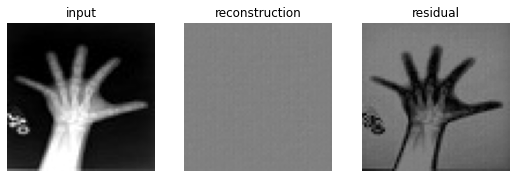

Iteration 50 - loss: 0.8881 - recon_loss: 0.0886 - kl_loss: 0.3997
Finished epoch 1
Iteration 100 - loss: 0.0724 - recon_loss: 0.0502 - kl_loss: 0.0111
Iteration 100 - val loss: 0.0627 - val recon_loss: 0.0486 - val kl_loss: 0.0071


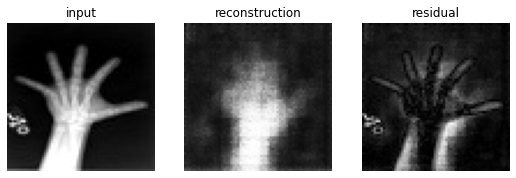

Finished epoch 2
Iteration 150 - loss: 0.0601 - recon_loss: 0.0470 - kl_loss: 0.0066
Finished epoch 3
Iteration 200 - loss: 0.0559 - recon_loss: 0.0451 - kl_loss: 0.0054
Iteration 200 - val loss: 0.0535 - val recon_loss: 0.0447 - val kl_loss: 0.0044


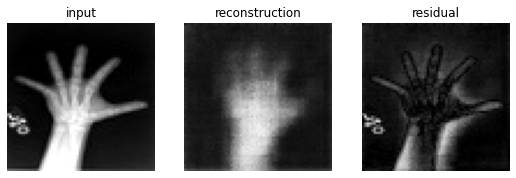

Iteration 250 - loss: 0.0532 - recon_loss: 0.0446 - kl_loss: 0.0043
Finished epoch 4
Iteration 300 - loss: 0.0521 - recon_loss: 0.0441 - kl_loss: 0.0040
Iteration 300 - val loss: 0.0538 - val recon_loss: 0.0438 - val kl_loss: 0.0050


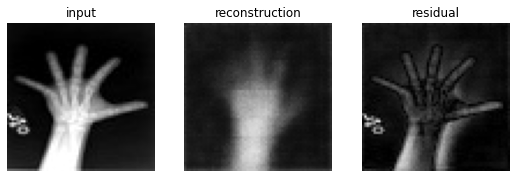

Finished epoch 5
Iteration 350 - loss: 0.0512 - recon_loss: 0.0440 - kl_loss: 0.0036
Finished epoch 6
Iteration 400 - loss: 0.0520 - recon_loss: 0.0448 - kl_loss: 0.0036
Iteration 400 - val loss: 0.0537 - val recon_loss: 0.0458 - val kl_loss: 0.0039


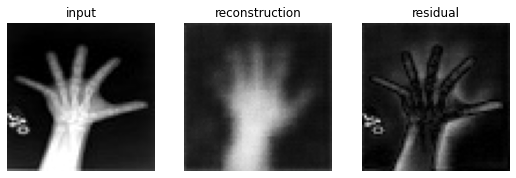

Finished epoch 7
Iteration 450 - loss: 0.0512 - recon_loss: 0.0436 - kl_loss: 0.0038
Iteration 500 - loss: 0.0499 - recon_loss: 0.0434 - kl_loss: 0.0033
Iteration 500 - val loss: 0.0518 - val recon_loss: 0.0439 - val kl_loss: 0.0040


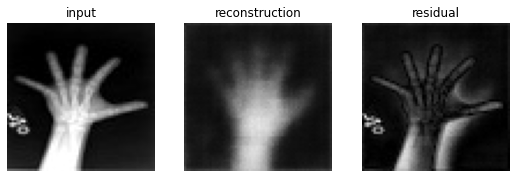

Finished epoch 8
Iteration 550 - loss: 0.0513 - recon_loss: 0.0440 - kl_loss: 0.0036
Finished epoch 9
Iteration 600 - loss: 0.0506 - recon_loss: 0.0434 - kl_loss: 0.0036
Iteration 600 - val loss: 0.0514 - val recon_loss: 0.0442 - val kl_loss: 0.0036


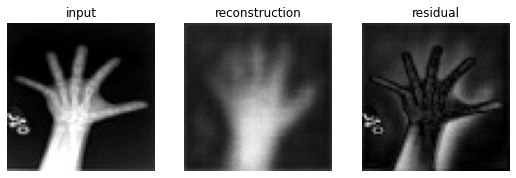

Finished epoch 10
Iteration 650 - loss: 0.0511 - recon_loss: 0.0439 - kl_loss: 0.0036
Finished epoch 11
Iteration 700 - loss: 0.0507 - recon_loss: 0.0432 - kl_loss: 0.0037
Iteration 700 - val loss: 0.0509 - val recon_loss: 0.0428 - val kl_loss: 0.0041


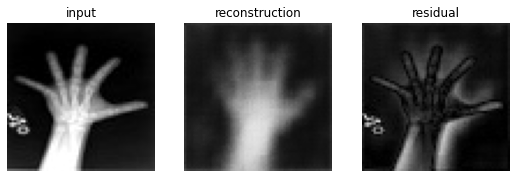

Iteration 750 - loss: 0.0502 - recon_loss: 0.0434 - kl_loss: 0.0034
Finished epoch 12
Iteration 800 - loss: 0.0544 - recon_loss: 0.0439 - kl_loss: 0.0052
Iteration 800 - val loss: 0.0553 - val recon_loss: 0.0415 - val kl_loss: 0.0069


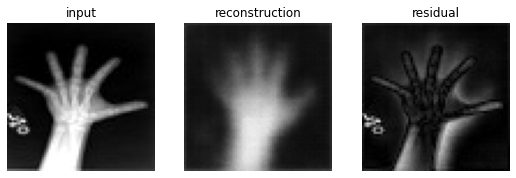

Finished epoch 13
Iteration 850 - loss: 0.0526 - recon_loss: 0.0439 - kl_loss: 0.0044
Finished epoch 14
Iteration 900 - loss: 0.0507 - recon_loss: 0.0438 - kl_loss: 0.0035
Iteration 900 - val loss: 0.0517 - val recon_loss: 0.0412 - val kl_loss: 0.0053


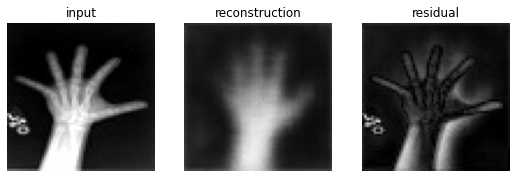

Finished epoch 15
Iteration 950 - loss: 0.0525 - recon_loss: 0.0441 - kl_loss: 0.0042
Finished training


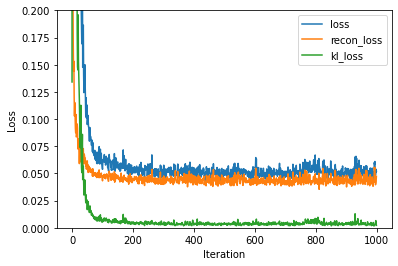

In [10]:
# Initialize Variational Autoencoder
vae = VAE(latent_dim=config.latent_dim).to(device)

# Optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=config.lr)

# Train
print('Start training...')
vae, vae_loss_history = train_vae(config, vae, optimizer, trainloader, valloader)

# Plot loss history
for k, v in vae_loss_history.items():
    plt.plot(v, label=k)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0, 0.2)
plt.show()

In [11]:
# Testing VAE

def vae_test_step(vae, x, device):
    vae.eval()
    x = x.to(device)
    with torch.no_grad():
        anomaly_scores = vae.anomaly_score(x)
    return anomaly_scores.cpu()

def test_vae(config, vae, testloader):
    scores = []
    labels = []
    vae.eval()
    for x, y in testloader:
        anomaly_scores = vae_test_step(vae, x, config.device)
        scores.extend(anomaly_scores.numpy())
        labels.extend(y.numpy())

    return np.array(scores), np.array(labels)

vae_scores, vae_labels = test_vae(config, vae, testloader)

ROC AUC: 0.9326


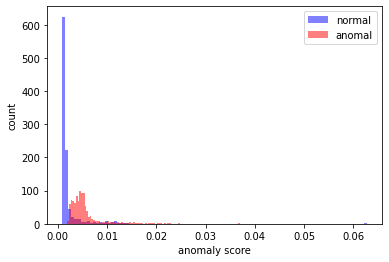

In [12]:
# Evaluation
auroc = roc_auc_score(vae_labels, vae_scores)
print(f'ROC AUC: {auroc:.4f}')

plot_anomaly_scores(vae_scores, vae_labels)

### References
[1] Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

[2] Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.